## Logistic Regression

Import necessary libraries to perform logistic regression.

In [1]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_auc_score
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### Data Prep for ML

Unpickle data and remove any NA values.

Concate "comment" and "parent_comment" for TD-idf and BoW from training and testing datasets using vstack.

In [2]:
train = pd.read_pickle("data/train.pkl").dropna()
test = pd.read_pickle("data/test.pkl").dropna()

In [3]:
train_parent_tdidf_csr = vstack(train["parent_comment_tdidf"])
test_parent_tdidf_csr = vstack(test["parent_comment_tdidf"])

train_tdidf_csr = vstack(train["comment_tdidf"])
test_tdidf_csr = vstack(test["comment_tdidf"])

train_parent_bow_csr = vstack(train["parent_comment_bow"])
test_parent_bow_csr = vstack(test["parent_comment_bow"])

train_bow_csr = vstack(train["comment_bow"])
test_bow_csr = vstack(test["comment_bow"])

In [4]:
train.columns

Index(['comment', 'parent_comment', 'comment_tokens', 'parent_comment_tokens',
       'comment_tokens_bigram', 'parent_comment_tokens_bigram',
       'comment_tokens_trigram', 'parent_comment_tokens_trigram',
       'comment_score', 'parent_comment_score',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive', 'comment_word_count',
       'parent_comment_word_count', 'comment_token_count',
       'parent_comment_token_count', 'comment_unique_word_count',
       'parent_comment_unique_word_count', 'comment_unique_token_count',
       'parent_comment_unique_token_count', 'comment_stopword_count',
       'parent_comment_stopword_count', 'comment_mean_word_length',
       'parent_comment_mean_word_length', 'comment_mean_token_length',
       'parent_comment_mean_token_length', 'comment_char_count',
       'parent_comment_char_count', 'comment_

List of features necessary for logistic regression.

In [5]:
list_of_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive']

Here we will standardize columns with boolean values. We will change from boolean to integer type and convert the features from a dense matrix to a sparse matrix using the function csr_matrix. We use MaxAbsScaler() to scale all data down to between -1 and 1 for easy analysis.

In [6]:
bool_cols = ['weighted_parent_sentiment_score_neutral',
             'weighted_parent_sentiment_score_positive',
             'weighted_comment_sentiment_score_neutral',
             'weighted_comment_sentiment_score_positive']

for col in bool_cols: #need to convert bool type to integer
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

X_train_gen_features = csr_matrix(train[list_of_features])

#Scaling Non-BoW/TDidf Features
X_train_scaler = MaxAbsScaler()
X_train_gen_features = X_train_scaler.fit_transform(X_train_gen_features)

X_test_gen_features = csr_matrix(test[list_of_features])
X_test_gen_features = X_train_scaler.transform(X_test_gen_features)

y_train_LR = train['label']
y_test_LR = test['label']

### Baseline 1: General Features

Performing Logistic Regression using general features as the baseline.

We will first train the training data using the LogisticRegression() model. We will then make predictions and compare the actual values and predicted values using the mean and stardard deviation of the area under the ROC curve. By looking at the difference in the area under curve measurements we can evaluate the accuracy and precision of logistic regression for this dataset.

In [7]:
#Data Specific Prep
X_train_LR = X_train_gen_features

In [8]:
k = 5

model = LogisticRegression(max_iter = 10000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5408218283514501
Standard Deviation of roc_auc: 0.0027109015058233072


In [9]:
coefficients = model.coef_[0]
feature_names = list_of_features  
feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

top_features = [feature for _, feature in feature_importance]
top_features

['comment_stopword_count',
 'comment_unique_word_count',
 'comment_punctuation_count',
 'comment_unique_token_count',
 'parent_comment_stopword_count',
 'parent_comment_unique_token_count',
 'comment_word_count',
 'parent_comment_punctuation_count',
 'parent_comment_word_count',
 'comment_token_count',
 'comment_number_count',
 'weighted_parent_sentiment_score_positive',
 'weighted_comment_sentiment_score_neutral',
 'weighted_parent_sentiment_score_neutral',
 'comment_mean_word_length',
 'parent_comment_char_count',
 'comment_char_count',
 'comment_mean_token_length',
 'comment_hashtag_count',
 'parent_comment_hashtag_count',
 'parent_comment_number_count',
 'parent_comment_mean_word_length',
 'parent_comment_token_count',
 'parent_comment_unique_word_count',
 'weighted_comment_sentiment_score_positive',
 'parent_comment_mean_token_length']

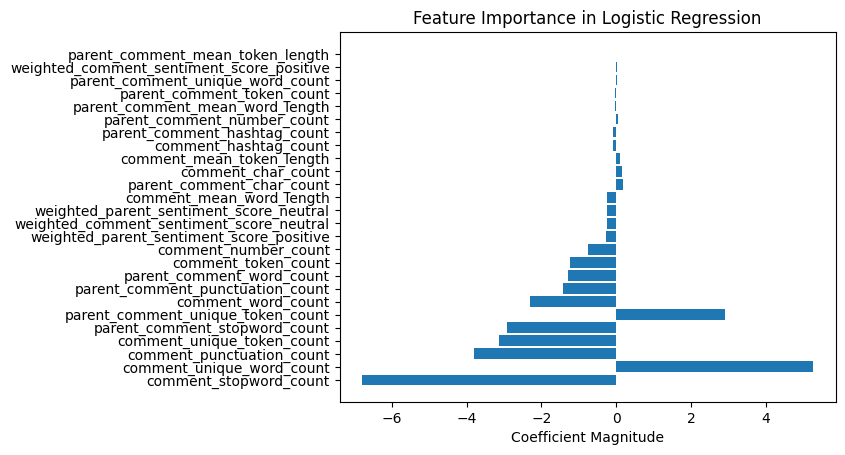

In [10]:
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.show()

In [46]:
from sklearn.metrics import roc_curve

fprs, tprs, thresholds = [], [], []

for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index], y_train_LR.iloc[val_index]

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    fpr, tpr, threshold = roc_curve(y_val, y_pred_proba)
    
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(threshold)

import csv

# Save collected ROC data points to a CSV file
with open('roc_curve_data.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['FPR', 'TPR', 'Threshold'])
    for fpr, tpr, threshold in zip(fprs, tprs, thresholds):
        writer.writerows(zip(fpr, tpr, threshold))



### Baseline 2: Comment BoW

Performing Logistic Regression using Comment Bag of Words as the baseline.

In [11]:
#Data Specific Prep
X_train_LR = train_bow_csr

In [12]:
k = 5

model = LogisticRegression(max_iter = 10000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
#unigram only: Mean roc_auc: 0.655919472075098
#unigram only: Standard Deviation of roc_auc: 0.0008334994867002629
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.6656443154062728
Standard Deviation of roc_auc: 0.0014910675476583078


In [13]:
coefficients = model.coef_[0]
feature_names = list_of_features  
feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

top_features = [feature for _, feature in feature_importance]
top_features

['comment_char_count',
 'comment_hashtag_count',
 'comment_mean_word_length',
 'comment_word_count',
 'parent_comment_unique_token_count',
 'comment_unique_word_count',
 'weighted_comment_sentiment_score_positive',
 'parent_comment_mean_word_length',
 'parent_comment_char_count',
 'parent_comment_hashtag_count',
 'weighted_parent_sentiment_score_neutral',
 'comment_punctuation_count',
 'parent_comment_unique_word_count',
 'parent_comment_number_count',
 'comment_number_count',
 'comment_unique_token_count',
 'parent_comment_stopword_count',
 'weighted_comment_sentiment_score_neutral',
 'weighted_parent_sentiment_score_positive',
 'parent_comment_word_count',
 'comment_stopword_count',
 'parent_comment_punctuation_count',
 'parent_comment_token_count',
 'parent_comment_mean_token_length',
 'comment_mean_token_length',
 'comment_token_count']

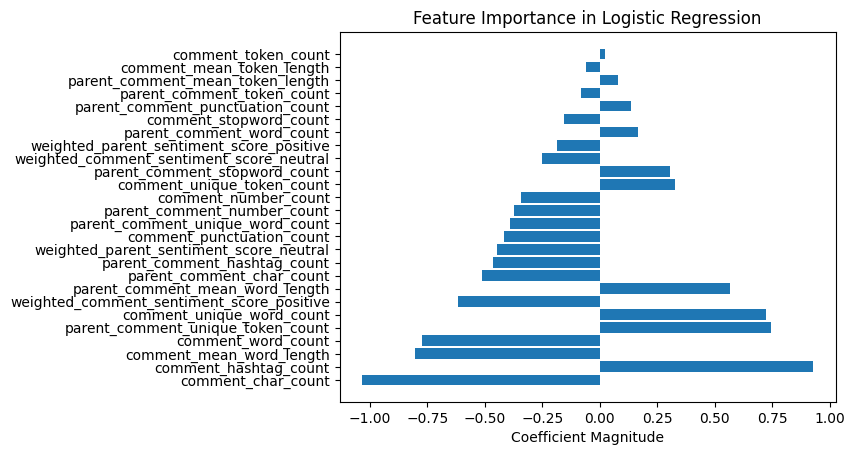

In [14]:
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Baseline 3: Comment TD-IDF

Performing Logistic Regression using Comment TD-idf as the baseline.

In [15]:
#Data Specific Prep
X_train_LR = train_tdidf_csr

In [16]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram only: Mean roc_auc: 0.6592838234414328
#unigram only: Standard Deviation of roc_auc: 0.0009248592313210024

Mean roc_auc: 0.6716092032791178
Standard Deviation of roc_auc: 0.002903530251986088


In [17]:
coefficients = model.coef_[0]
feature_names = list_of_features  
feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

top_features = [feature for _, feature in feature_importance]
top_features

['comment_word_count',
 'parent_comment_unique_token_count',
 'comment_char_count',
 'comment_mean_word_length',
 'comment_hashtag_count',
 'parent_comment_number_count',
 'parent_comment_mean_word_length',
 'parent_comment_word_count',
 'parent_comment_char_count',
 'comment_unique_word_count',
 'parent_comment_hashtag_count',
 'weighted_parent_sentiment_score_neutral',
 'comment_number_count',
 'comment_unique_token_count',
 'parent_comment_stopword_count',
 'comment_stopword_count',
 'parent_comment_punctuation_count',
 'weighted_comment_sentiment_score_positive',
 'comment_mean_token_length',
 'parent_comment_unique_word_count',
 'weighted_parent_sentiment_score_positive',
 'comment_punctuation_count',
 'comment_token_count',
 'parent_comment_token_count',
 'weighted_comment_sentiment_score_neutral',
 'parent_comment_mean_token_length']

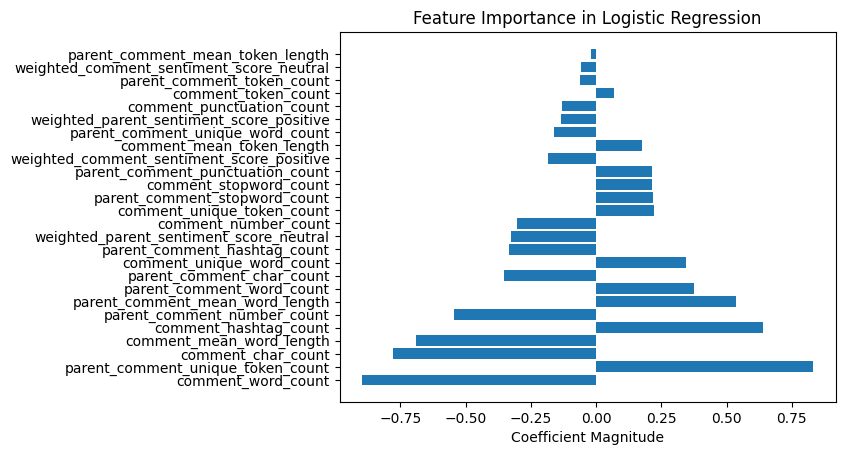

In [18]:
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Baseline 4: General Features + BoW

Performing Logistic Regression using both General Features and Comment Bag of Words as the baseline.

In [19]:
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [20]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6578548281567246
#unigram: Standard Deviation of roc_auc: 0.0015689875036237729

Mean roc_auc: 0.66791462593004
Standard Deviation of roc_auc: 0.0011969773040002838


In [21]:
coefficients = model.coef_[0]
feature_names = list_of_features  
feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

top_features = [feature for _, feature in feature_importance]
top_features

['comment_unique_token_count',
 'comment_unique_word_count',
 'comment_punctuation_count',
 'comment_stopword_count',
 'parent_comment_unique_token_count',
 'parent_comment_stopword_count',
 'comment_token_count',
 'comment_word_count',
 'parent_comment_word_count',
 'parent_comment_punctuation_count',
 'parent_comment_number_count',
 'comment_mean_word_length',
 'comment_char_count',
 'weighted_parent_sentiment_score_positive',
 'weighted_parent_sentiment_score_neutral',
 'parent_comment_unique_word_count',
 'weighted_comment_sentiment_score_neutral',
 'parent_comment_token_count',
 'comment_number_count',
 'parent_comment_char_count',
 'parent_comment_mean_token_length',
 'weighted_comment_sentiment_score_positive',
 'parent_comment_mean_word_length',
 'parent_comment_hashtag_count',
 'comment_hashtag_count',
 'comment_mean_token_length']

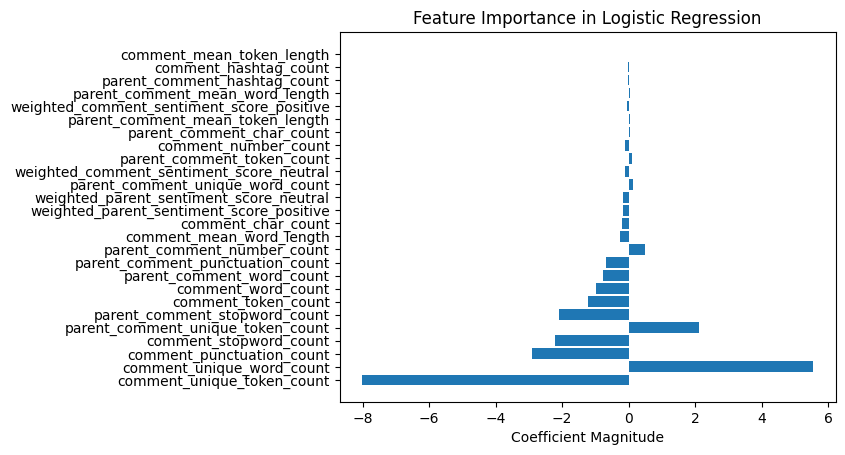

In [22]:
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Baseline 5: General Features + TD-IDF

Performing Logistic Regression using both General Features and TD-idf as the baseline.

In [23]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr])

In [24]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6623742530514969
#unigram: Standard Deviation of roc_auc: 0.0010939794906847484

Mean roc_auc: 0.6735259270913811
Standard Deviation of roc_auc: 0.0026192141835243202


In [25]:
coefficients = model.coef_[0]
feature_names = list_of_features  
feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

top_features = [feature for _, feature in feature_importance]
top_features

['comment_unique_word_count',
 'comment_stopword_count',
 'comment_unique_token_count',
 'comment_punctuation_count',
 'parent_comment_stopword_count',
 'parent_comment_unique_token_count',
 'comment_word_count',
 'comment_token_count',
 'parent_comment_word_count',
 'parent_comment_punctuation_count',
 'comment_char_count',
 'parent_comment_number_count',
 'comment_number_count',
 'parent_comment_unique_word_count',
 'parent_comment_token_count',
 'comment_mean_word_length',
 'weighted_parent_sentiment_score_positive',
 'weighted_parent_sentiment_score_neutral',
 'weighted_comment_sentiment_score_neutral',
 'weighted_comment_sentiment_score_positive',
 'parent_comment_char_count',
 'parent_comment_mean_word_length',
 'parent_comment_mean_token_length',
 'comment_mean_token_length',
 'comment_hashtag_count',
 'parent_comment_hashtag_count']

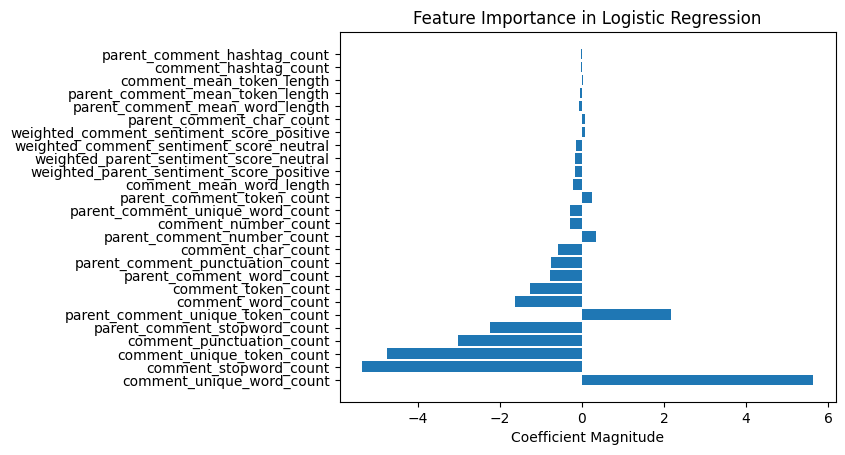

In [26]:
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Baseline 6: General Features + Comment TDIDF + Parent TDIDF

Performing Logistic Regression using General Features, Comment TD-idf and Parent comment TD-idf as the baseline.

In [27]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr,train_parent_tdidf_csr])

In [28]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6595766552618814
#unigram: Standard Deviation of roc_auc: 0.0020504330756799696

Mean roc_auc: 0.6689354002906421
Standard Deviation of roc_auc: 0.0022898651527621856


In [29]:
coefficients = model.coef_[0]
feature_names = list_of_features  
feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

top_features = [feature for _, feature in feature_importance]
top_features

['comment_unique_word_count',
 'comment_stopword_count',
 'comment_unique_token_count',
 'comment_punctuation_count',
 'comment_word_count',
 'parent_comment_stopword_count',
 'comment_token_count',
 'parent_comment_unique_word_count',
 'parent_comment_unique_token_count',
 'comment_char_count',
 'parent_comment_word_count',
 'comment_number_count',
 'parent_comment_number_count',
 'parent_comment_token_count',
 'comment_mean_word_length',
 'weighted_comment_sentiment_score_neutral',
 'parent_comment_char_count',
 'weighted_parent_sentiment_score_neutral',
 'weighted_comment_sentiment_score_positive',
 'weighted_parent_sentiment_score_positive',
 'parent_comment_mean_word_length',
 'parent_comment_mean_token_length',
 'parent_comment_punctuation_count',
 'comment_mean_token_length',
 'comment_hashtag_count',
 'parent_comment_hashtag_count']

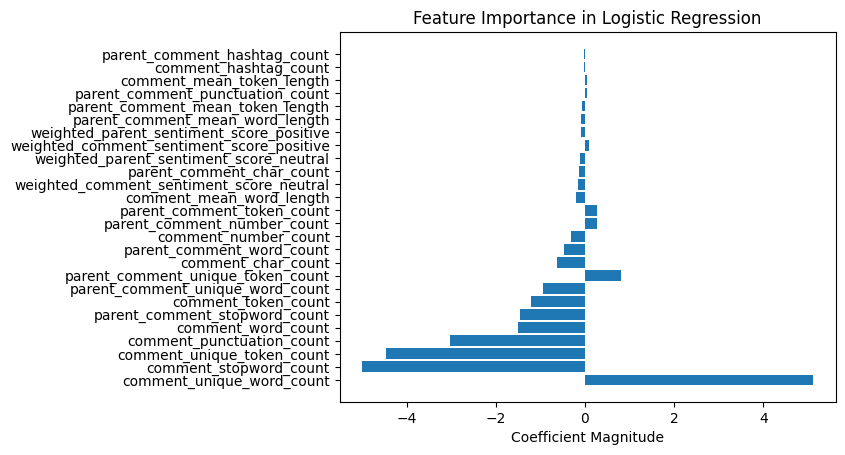

In [30]:
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Baseline 7: General Features + Parent TDIDF

Performing Logistic Regression using both General Features and Parent comment TD-idf as the baseline.

In [31]:
X_train_LR = hstack([X_train_gen_features,train_parent_tdidf_csr])

In [32]:
k = 5

model = LogisticRegression(max_iter = 100000)
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.570165520029702
#unigram: Standard Deviation of roc_auc: 0.002821502726381473

Mean roc_auc: 0.5676122286586163
Standard Deviation of roc_auc: 0.0032312662177705486


In [33]:
coefficients = model.coef_[0]
feature_names = list_of_features  
feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

top_features = [feature for _, feature in feature_importance]
top_features

['comment_stopword_count',
 'comment_unique_word_count',
 'comment_punctuation_count',
 'comment_unique_token_count',
 'comment_word_count',
 'parent_comment_stopword_count',
 'parent_comment_unique_word_count',
 'comment_token_count',
 'parent_comment_unique_token_count',
 'parent_comment_word_count',
 'comment_number_count',
 'comment_char_count',
 'parent_comment_number_count',
 'parent_comment_token_count',
 'comment_mean_word_length',
 'weighted_comment_sentiment_score_neutral',
 'parent_comment_char_count',
 'weighted_parent_sentiment_score_neutral',
 'weighted_parent_sentiment_score_positive',
 'parent_comment_mean_word_length',
 'parent_comment_mean_token_length',
 'parent_comment_punctuation_count',
 'comment_mean_token_length',
 'comment_hashtag_count',
 'weighted_comment_sentiment_score_positive',
 'parent_comment_hashtag_count']

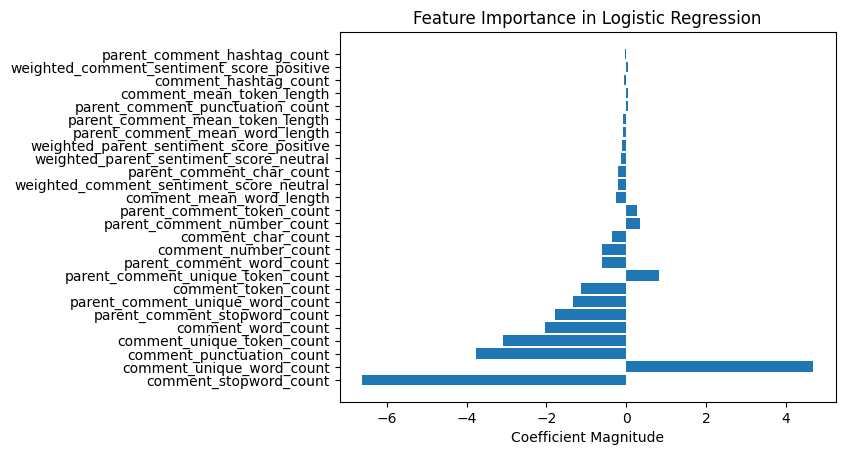

In [34]:
importance, features = zip(*feature_importance)
plt.barh(features, importance)
plt.xlabel('Coefficient Magnitude')
plt.title('Feature Importance in Logistic Regression')
plt.show()

### Hyper Parameter Tuning with Grid Search CV

Baseline 5: General Features + TD-idf has the highest mean roc_auc score (0.67367). This means that it is the best performing classifier. We will now perform hyperparameter tuning on this to increase the model performance. We will use GridSearchCV to cross validate all possible hyperparameter combinations and pick the best performing hyperparameters.

In [35]:
### Using gen features and tdidf
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr])

In [36]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
}

In [37]:
grid_search = GridSearchCV(LogisticRegression(max_iter=100000), param_grid, cv=5, scoring='roc_auc', verbose=4)
grid_search.fit(X_train_LR, y_train_LR)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.529 total time=   0.1s
[CV 2/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.530 total time=   0.0s
[CV 3/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.528 total time=   0.1s
[CV 4/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.530 total time=   0.0s
[CV 5/5] END C=0.001, penalty=l1, solver=liblinear;, score=0.533 total time=   0.0s
[CV 1/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ...C=0.001, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.001, penalty=l2, solver=liblinear;, score=0.593 total time=   0.1s
[CV 2/5] END C=0.001, penalty

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packag

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=100000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'lbfgs']},
             scoring='roc_auc', verbose=4)

In [38]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best score achieved during grid search
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Score: 0.7361586791350682


Here we will test out the model using the best hyperparameters.

In [39]:
# Best estimator (the fitted model with the best parameters)
best_estimator = grid_search.best_estimator_
print("Best Estimator:", best_estimator)

# Results for all parameter combinations
cv_results = grid_search.cv_results_

Best Estimator: LogisticRegression(C=1, max_iter=100000)


In [40]:
# Display CV results as a table
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

pd.set_option('display.max_colwidth',None)
results_df = pd.DataFrame({'Params':params,'Mean Score':mean_test_scores,'STD':std_test_scores})
results_df["Params"] = results_df["Params"].apply(lambda x: ', '.join([f'{key}: {value}' for key, value in x.items()]))
results_df.sort_values('STD', inplace=True)
results_df.sort_values('Mean Score', ascending=False,inplace=True)
results_df.dropna() # Na values when solver is lbfgs and penalty function is l1 since lbfgs does not support l1

#for mean_score, std_score, param in zip(mean_test_scores, std_test_scores, params):
    #print(f"Mean Score: {mean_score:.3f} (±{std_score:.3f}) for params: {param}")

,Params,Mean Score,STD
15,"C: 1, penalty: l2, solver: lbfgs",0.736159,0.002300
14,"C: 1, penalty: l2, solver: liblinear",0.736158,0.002302
12,"C: 1, penalty: l1, solver: liblinear",0.732838,0.001879
10,"C: 0.1, penalty: l2, solver: liblinear",0.721027,0.002224
11,"C: 0.1, penalty: l2, solver: lbfgs",0.721023,0.002223
18,"C: 10, penalty: l2, solver: liblinear",0.714444,0.002506
19,"C: 10, penalty: l2, solver: lbfgs",0.714436,0.002503
16,"C: 10, penalty: l1, solver: liblinear",0.692631,0.002924
8,"C: 0.1, penalty: l1, solver: liblinear",0.681925,0.001944
23,"C: 100, penalty: l2, solver: lbfgs",0.679831,0.002754


### Compare to Test Set

Here we can see that hyperparameter tuning has increased the ROC_AUC score from 0.67367 to 0.67657.

In [41]:
X_test_LR = hstack([X_test_gen_features,test_tdidf_csr])
#X_test_LR = scaler.fit_transform(X_test_LR)

In [42]:
y_pred_test = best_estimator.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")
#unigram only: roc_auc test: 0.6626099986586551

roc_auc test: 0.67642456218356
